# VGG16/3

## Data preparation

In [ ]:
pip install colorama

In [ ]:
from keras.datasets import mnist
from tensorflow.image import resize
from keras.utils import to_categorical
from colorama import Fore
import numpy as np

### 1. Load the MNIST dataset.

The **MNIST** dataset consists of 28x28 grayscale images, but VGG16 expects input images of size at least 32x32 and in three channels (RGB).

In [ ]:
# Get data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Check if split ratio is correct
assert train_images.shape == (60000, 28, 28)
assert test_images.shape == (10000, 28, 28)
assert train_labels.shape == (60000,)
assert test_labels.shape == (10000,)

# Combine train and test sets
images = np.concatenate((train_images, test_images))
labels = np.concatenate((train_labels, test_labels))

print(f'{Fore.GREEN}Images loaded succesfully!{Fore.WHITE}')

11490434/11490434 [==============================] - 0s 0us/step
Images loaded succesfully!


### 2. Resizing

Resizing the images from grayscale to RGB and adjusting them to the size compatible with VGG16 (we'll stick with 32x32 for this example).

In [ ]:
# Resize images to 32x32 and convert to RGB by repeating the grayscale channel 3 times

images_rgb = np.repeat(images[..., np.newaxis], 3, axis=-1)
print("Shape before resizing:", images_rgb.shape)

Shape before resizing: (70000, 28, 28, 3)


In [ ]:
images_resized = resize(images_rgb, [32, 32])
print("Shape before resizing:", images_resized.shape)

Shape before resizing: (70000, 32, 32, 3)


### 3. Normalizing the pixel value

VGG16 models usually work with pixel values in the range [0, 1] or [-1, 1]. We'll normalize our pixel values to [0, 1].

In [ ]:
images_resized /= 255.0

### 4. Labels preparation

 Since VGG16 is a model used for classification tasks with more than 10 classes, ensure the labels are one-hot encoded.

In [ ]:
y_one_hot = to_categorical(labels, 10)

### 5. Split dataset

Divide the dataset into training and validation sets with an 80/20 split.
Choose data randomly

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf

# Convert TensorFlow tensors to numpy arrays if they are not already
images_resized_np = images_resized.numpy() if isinstance(images_resized, tf.Tensor) else images_resized
labels_one_hot_np = y_one_hot.numpy() if isinstance(y_one_hot, tf.Tensor) else y_one_hot

# Split the data randomly into training and validation sets with an 80/20 ratio
x_train_np, x_test_np, y_train_np, y_test_np = train_test_split(images_resized_np, labels_one_hot_np, test_size=0.2, random_state=42)

# If needed, convert back to TensorFlow tensors
x_train, x_test = tf.convert_to_tensor(x_train_np), tf.convert_to_tensor(x_test_np)
y_train, y_test = tf.convert_to_tensor(y_train_np), tf.convert_to_tensor(y_test_np)

print(f'Training set images shape: {x_train.shape}')
print(f'Validation set images shape: {x_test.shape}')
print(f'Training set labels shape: {y_train.shape}')
print(f'Validation set labels shape: {y_test.shape}')


Training set images shape: (56000, 32, 32, 3)
Validation set images shape: (14000, 32, 32, 3)
Training set labels shape: (56000, 10)
Validation set labels shape: (14000, 10)


## Building model

In [ ]:
from keras.applications import VGG16
from keras import layers, models

In [ ]:
# Load the VGG16 model pre-trained on ImageNet data, excluding the top fully connected layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the layers of the base model to prevent them from being updated during the first training phase
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top
model = models.Sequential()

# Add the pre-trained VGG16 base model
model.add(base_model)

# Add new layers on top
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))  # 10 classes for digit classification

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 14848586 (56.64 MB)
Trainable params: 133898 (523.04 KB)
Non-trainable params: 14714688 (56.13 MB)
__________

# Train model

In [ ]:
import time
import matplotlib.pyplot as plt
from keras.callbacks import History

In [ ]:
# Measure the training time
start_time = time.time()

# Train the model
history = model.fit(x_train, y_train,
                    epochs=15,
                    batch_size=64,
                    validation_data=(x_test, y_test),
                    verbose=1)

end_time = time.time()
training_time = end_time - start_time
print(f"Training completed in: {training_time:.2f} seconds")

Epoch 1/15
875/875 [==============================] - 740s 844ms/step - loss: 0.4928 - accuracy: 0.8487 - val_loss: 0.2126 - val_accuracy: 0.9353
Epoch 2/15
875/875 [==============================] - 738s 844ms/step - loss: 0.2153 - accuracy: 0.9348 - val_loss: 0.1516 - val_accuracy: 0.9511
Epoch 3/15
875/875 [==============================] - 722s 826ms/step - loss: 0.1741 - accuracy: 0.9464 - val_loss: 0.1321 - val_accuracy: 0.9594
Epoch 4/15
875/875 [==============================] - 711s 813ms/step - loss: 0.1523 - accuracy: 0.9520 - val_loss: 0.1176 - val_accuracy: 0.9633
Epoch 5/15
875/875 [==============================] - 714s 816ms/step - loss: 0.1375 - accuracy: 0.9556 - val_loss: 0.1119 - val_accuracy: 0.9643
Epoch 6/15
875/875 [==============================] - 711s 813ms/step - loss: 0.1312 - accuracy: 0.9580 - val_loss: 0.1025 - val_accuracy: 0.9666
Epoch 7/15
875/875 [==============================] - 712s 814ms/step - loss: 0.1220 - accuracy: 0.9612 - val_loss: 0.1074 -

In [ ]:
type(history.history['val_accuracy'])

list

# Plots

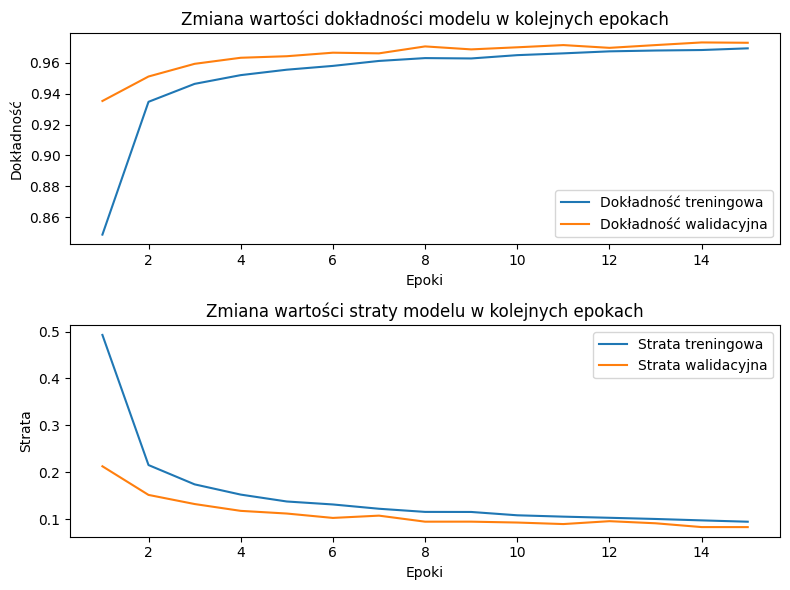

In [ ]:
# Plotting training accuracy and loss
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

epoki = range(1, len(history.history['accuracy']) + 1)

# Accuracy plot
axs[0].plot(epoki, history.history['accuracy'], label='Dokładność treningowa')
axs[0].plot(epoki, history.history['val_accuracy'], label='Dokładność walidacyjna')
axs[0].set_title('Zmiana wartości dokładności modelu w kolejnych epokach')
axs[0].set_ylabel('Dokładność')
axs[0].set_xlabel('Epoki')
axs[0].legend(loc='lower right')

# Loss plot
axs[1].plot(epoki, history.history['loss'], label='Strata treningowa')
axs[1].plot(epoki, history.history['val_loss'], label='Strata walidacyjna')
axs[1].set_title('Zmiana wartości straty modelu w kolejnych epokach')
axs[1].set_ylabel('Strata')
axs[1].set_xlabel('Epoki')
axs[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

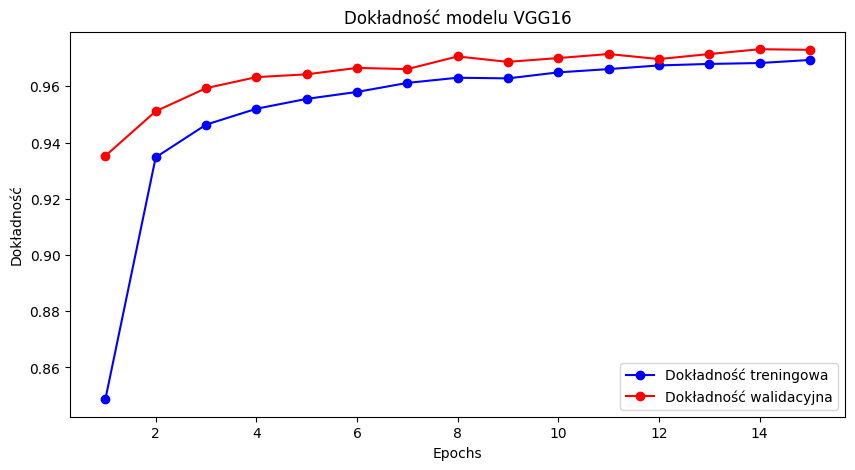

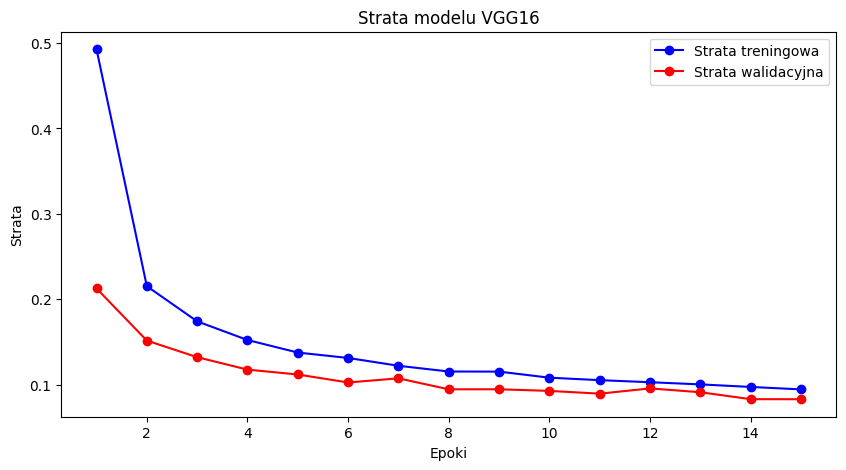

In [ ]:
import matplotlib.pyplot as plt

# Extract accuracy and loss from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, 'bo-', label='Dokładność treningowa')
plt.plot(epochs, val_acc, 'ro-', label='Dokładność walidacyjna')
plt.title('Dokładność modelu VGG16')
plt.xlabel('Epochs')
plt.ylabel('Dokładność')
plt.legend(loc='lower right')
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'bo-', label='Strata treningowa')
plt.plot(epochs, val_loss, 'ro-', label='Strata walidacyjna')
plt.title('Strata modelu VGG16')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()
plt.show()

In [ ]:
model.save('vgg_16')

In [ ]:
model.save('vgg_16.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.models import load_model

model1 = load_model('vgg_16')

In [ ]:
# Print each layer's name and output shape
for layer in model1.layers:
    print(layer.name, layer.output_shape)

vgg16 (None, 1, 1, 512)
flatten (None, 512)
dense (None, 256)
dropout (None, 256)
dense_1 (None, 10)


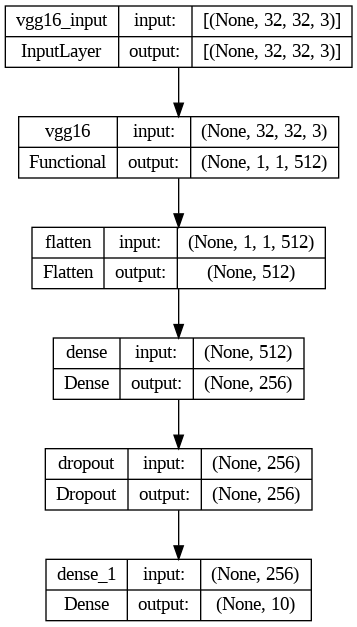

In [ ]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
import pickle

# Assuming `history` is the object returned by model.fit()
with open('vgg16_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [ ]:
with open('vgg16_history.pkl', 'rb') as file:
    loaded_history = pickle.load(file)

# Confusion Matrix

In [ ]:
import numpy as np

start_time = time.time()

# Make predictions on the test set
predictions = model.predict(x_test)

end_time = time.time()
predicting_time = end_time - start_time
print(f"Prediction completed in: {predicting_time:.2f} seconds")

# Convert predictions and y_test to class labels
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)


438/438 [==============================] - 148s 337ms/step
Prediction completed in: 202.16 seconds


In [ ]:
!pip install scikit-learn

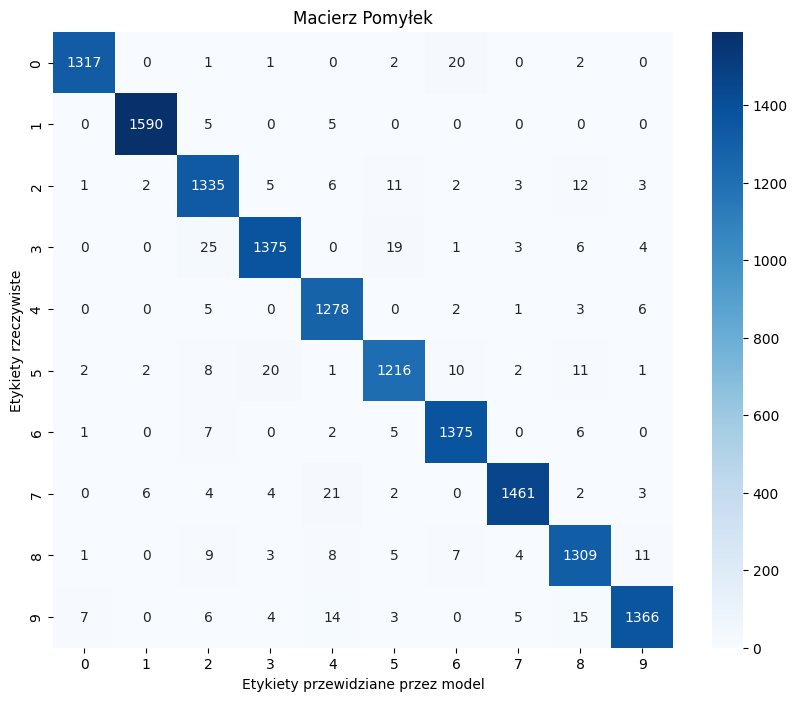

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Etykiety przewidziane przez model')
plt.ylabel('Etykiety rzeczywiste')
plt.title('Macierz ')
plt.show()


## ROC i AUC

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming x_test is your test set and model is your trained VGG16 model
y_pred_probs = model1.predict(x_test)

438/438 [==============================] - 159s 363ms/step


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarize the labels in a one-vs-all fashion
n_classes = y_test.shape[1]
y_test_binarized = label_binarize(y_test, classes=[*range(n_classes)])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Optionally, compute the micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Calculate the average AUC
average_auc = np.mean([roc_auc[i] for i in range(n_classes)])
print(f'Average AUC: {average_auc:.4f}')


Average AUC: 0.9995


In [ ]:
for i in range(n_classes):
  print(f'AUC for class {i}:', round(roc_auc[i]*100, 3))

AUC for class 0: 99.988
AUC for class 1: 99.998
AUC for class 2: 99.922
AUC for class 3: 99.922
AUC for class 4: 99.969
AUC for class 5: 99.883
AUC for class 6: 99.974
AUC for class 7: 99.968
AUC for class 8: 99.907
AUC for class 9: 99.928


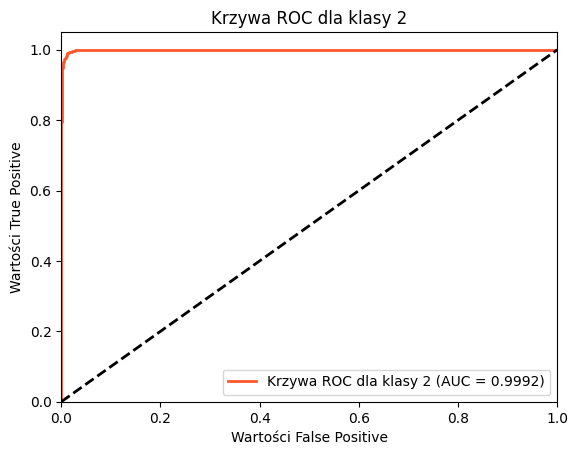

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
colors = plt.cm.rainbow(np.linspace(0, 1, n_classes))

plt.plot(fpr[2], tpr[2], color=colors[8], lw=lw, label=f'Krzywa ROC dla klasy 2 (AUC = {roc_auc[2]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Wartości False Positive')
plt.ylabel('Wartości True Positive')
plt.title('Krzywa ROC dla klasy 2')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Precision
precision = precision_score(true_classes, predicted_classes, average='macro')
print(f'Precision: {precision}')

# Recall
recall = recall_score(true_classes, predicted_classes, average='macro')
print(f'Recall: {recall}')

# F1 Score
f1 = f1_score(true_classes, predicted_classes,  average='macro')
print(f'F1 Score: {f1}')


Precision: 0.9725160785064594
Recall: 0.9727016195096508
F1 Score: 0.9725480374125006
